In [ ]:
import time

import scipy.interpolate
from scipy.integrate import solve_ivp
from numpy import *
import matplotlib; matplotlib.use("nbAgg")
from matplotlib.pyplot import *
%matplotlib notebook 

# Dummy (Explicit Euler) Solver

In [24]:
def basic_solve_ivp(fun, t_span, y0, max_step=1e-7, dense_output=False, **extra):
    result = {}

    t0, t1 = t_span
    t = t0
    y = array(y0) # check 1d
    ts = [t]
    ys = [y]
    try:
        while ts[-1] < t1:
            t, y = ts[-1], ys[-1]
            #print("t", t)
            t_next = min(t1, t + max_step)
            dt = t_next - t
            y_next = y + dt * fun(t, y)
            ts.append(t_next)
            ys.append(y_next)
            #print("ts", ts)
        result["success"] = True
    except: # too wide. What can happen here ? nan stuff ?
        result["success"] = False
        raise
    result["t"] = array(ts)
    result["y"] = array(ys)
    if dense_output:
        #print("result", result)
        result["sol"] = scipy.interpolate.interp1d(result["t"], result["y"], axis=0, fill_value="extrapolate")
    else:
        result["sol"] = None
    return result  
    

<IPython.core.display.Javascript object>


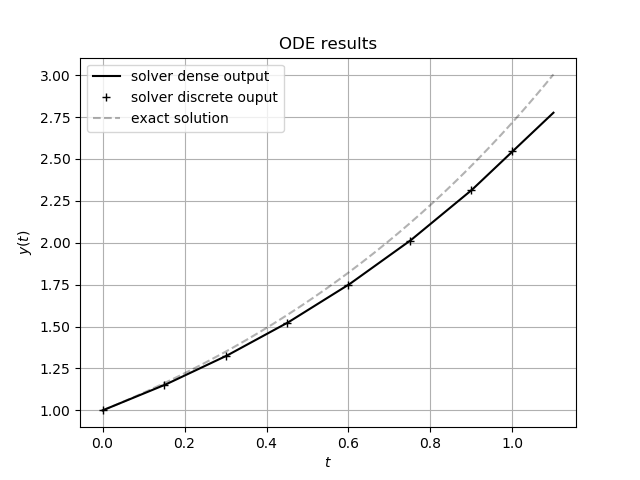

In [34]:
def fun(t, y):
    return y
y0 = [1.0]
t0, t1 = 0.0, 1.0
r = basic_solve_ivp(fun, (t0, t1), y0, max_step=0.15, dense_output=True)
figure()
t = linspace(t0, 1.1 * t1, 1000)
plot(t, r["sol"](t), "k", label="solver dense output")
plot(r["t"], r["y"], "k+", label="solver discrete ouput")
plot(t, exp(t), "k--", alpha=0.3, label="exact solution")
grid(True)
title("ODE results")
xlabel("$t$")
ylabel("$y(t)$")
_ = legend()

# Discover `solve_ivp`

<https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html>

In [ ]:
def fun(t, y):
    return y

-------------

NOTA: here we have a purely technical lab with no "application" or modeling only to discover how to use the `solve_ivp` API and to analyse/discover pitfalls of the system, in connexion with the mathematical properties of the ODES.

NOTA: somehow we could "lump" together (from a practical perspective):

  - non-existence of solution and finite-time blow-up,
  
  - multiple solutions and non-continuity wrt the initial condition.

TODO:

  - start with an ODE that does not explode in finite-time ...
  
  - add the possible "issues" into the mix and ask the students to diagnose them:
    no existence at all, finite-time blow-up, multiple solutions (can we demo this),
    non-continuity wrt initial conditions?
  
  - scalar or 2D ? Somehow 2D is SIMPLER since you cannot try float stuff, only arrays.
    Still, try 1D
    
  - initial condition time span, etc.
  
  - simulate, check sucess, investigate what can go wrong (later ?)
    
  - play with precision (emphasize discrete stuff ?), control step size explicitely ?
  
  - discrete data vs continous ("dense") output and how it rocks. Compare.
    continuous output is tricky when your data terminates early.
  
  - events ? (check "too big" or check when enters some suitable neighbourhood for a stable system ?)
  
  - fct that returns some Nan ?

  - place of Lunar Lander and pendulum ?


TODO: 2D (or more) example, before the trouble-shooting section maybe.

TODO:
   - display examples with errors (the classic ones ?), ask them to correct the issue ?

# The one that goes well


Simple example where all goes well, demo data points, "dense output", precision control, etc.
Use a simple example where all goes well to demonstrate the API. Explain why discrete data is nice since it computes the minimal density of points necessary to carry the computations are a required precision (also direct control of max_step can be handy), but how dense_output is generally better / higher-level since you can resample to focus on whatever time samples you really need.

-----

# Discontinuous RHS

In [ ]:
def fun(t, y):
    if y <= 0.0:
        return 1.0
    else:
        return -1.0

In [ ]:
r = solve_ivp(fun=fun, t_span=(-1.0, 2.0), y0=[-1.0], dense_output=True)
r.success

In [ ]:
figure()
t = linspace(-1.0, 2.0, 1000)
plot(t, r.sol(t)[0], "k--")

OK, nice example above: the solver does not report an error, but what we see -- the solution seem to stabilize at 0 -- is *not* a solution of the ODEs since there is no such thing ! A graphical analysis of the plot shows that the time step has to decrease dramatically (TODO: show points) to ensure a given precision (next step: relax the precision to make this clear). On the other hand it's not too hard to understand why the solver behaves like this (hopefully).

In [ ]:
r = solve_ivp(fun=fun, t_span=(-1.0, 2), y0=[-1.0], atol=1e-3, dense_output=True)

In [ ]:
figure()
t = linspace(-1.0, 2.0, 1000)
plot(t, r.sol(t)[0], 'grey')
plot(r.t, r.y[0], "k+")

# Finite-Time Blowup

In [ ]:
def fun(t, y):
    return y*y

In [ ]:
r = solve_ivp(fun=fun, t_span=(0.0, 2.0), y0=[1.0], dense_output=True)
r.success

In [ ]:
figure()
t = linspace(0.0, 2.0, 1000)
plot(t, r.sol(t)[0])
plot(r.t, r.y[0], "k")

Here the issue is a finite-time blow-up. At least the ODE solver detects this ! Not much we can do really about this one, this is structural. BUT, if you don't check success and use the dense output, you're screwed again ... as the dense output will happily EXTRAPOLATE the discrete data it has.

# Multiple Solution / Sensitivity of the Solution

In [ ]:
def fun(t, y):
    return sqrt(abs(y))

In [ ]:
r = solve_ivp(fun=fun, t_span=(0.0, 1.0), y0=[1e-200], dense_output=True)

In [ ]:
figure()
t = linspace(0.0, 1.0, 1000)
plot(t, r.sol(t)[0])

Here this is nice: of course we cannot demonstrate with a deterministic engine that there are multiple solutions,
BUT we can show that IC to 0 and to anything very small give VERY different result and that make the small smaller does NOT solve the issue.

----------

# Discontinuous RHS (wrt t)

In [ ]:
def fun(t, y):
    return array((t % 1.0) > 0.5, dtype=float)

In [ ]:
t = r_[0.0:10.0:0.25]

In [ ]:
figure()
plot(t, fun(t, 0))
xlabel("$t")
ylabel("$f(t, y)$")
grid()

In [ ]:
def y(t, y0=0.0):
    return y0 + 0.5 * floor(t / 1.0) + clip(mod(t, 1.0) - 0.5, 0.0, inf)
    

In [ ]:
figure()
plot(t, y(t))

In [ ]:
r = solve_ivp(fun=fun, t_span=(0.0, 10.0), y0=[0.0], dense_output=True)

In [ ]:
figure()
t = linspace(0.0, 10.0, 1000)
plot(t, y(t), "k", alpha=0.3)
plot(t, r.sol(t)[0])
plot(r.t, r.y[0], "k+")

Nota: this example suggest another example where the system gets "too confident" and a manual control of max_step is still the best thing you can do. Nope: here it's the interpolator that does not make much sense, since it assumes a regularity on the solution that does not exist. Here maybe a change of scheme would be the right thing to do ... Actually, RK23 does make a much better job here and LSODA is also GREAT. NOTA: indexerror here for Radau and BDF ... How come ? Probably connected to how `fun` is written ... Like not vectorized or something. Mmm I vectorized the function
and still have the issue ? Beurk, would need investigation.

Yup, so apparently, Radau and BDF send array arguments (even with a single value) and expect an output of the same size, while the other solvers happily send scalars ? Or at least accept scalars as outputs ? 

In [ ]:
r = solve_ivp(fun=fun, t_span=(0.0, 10.0), y0=[0.0], dense_output=True, max_step=0.5)

In [ ]:
figure()
t = linspace(0.0, 10.0, 1000)
plot(t, y(t), "k", alpha=0.3)
plot(t, r.sol(t)[0])
plot(r.t, r.y[0], "k+")

In [ ]:
options = {"dense_output": True, "method": "LSODA"}

In [ ]:
r = solve_ivp(fun=fun, t_span=(0.0, 10.0), y0=[0.0], **options)
figure()
plot(t, r.sol(t)[0])
plot(t, y(t), "k", alpha=0.3)
plot(r.t, r.y[0], "k+")

In [ ]:
options = {"dense_output": True, "method": "LSODA", "max_step": 0.5}

In [ ]:
r = solve_ivp(fun=fun, t_span=(0.0, 10.0), y0=[0.0], **options)
figure()
plot(t, r.sol(t)[0])
plot(t, y(t), "k", alpha=0.3)
plot(r.t, r.y[0], "k+")

In [ ]:
options = {"dense_output": True, "method": "RK23"}

r = solve_ivp(fun=fun, t_span=(0.0, 10.0), y0=[1.0], **options)
figure()
plot(t, r.sol(t)[0])
plot(t, y(t), "k", alpha=0.3)


plot(r.t, r.y[0], "k+")

In [ ]:
options = {"dense_output": True, "method": "BDF"}

def fun(t, y):
    f = ((t % 1.0) > 0.5) * ones_like(y)
    #print("t", t, "y", y, "f", f)
    return f

r = solve_ivp(fun=fun, t_span=(0.0, 10.0), y0=[0.0], **options)
print("success", r.success)
figure()
plot(t, r.sol(t)[0])
plot(t, y(t), "k", alpha=0.3)
plot(r.t, r.y[0], "k+")

In [ ]:
def fun(t, y):
    if y <= 0.0:
        r = 1.0
    else:
        r = -1.0
    r = ones_like(y)
    print(t, y, r)    
    return r

In [ ]:
r = solve_ivp(fun=fun, t_span=(-1.0, 2), y0=[-1.0], method="Radau")